In [64]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller, coint
from scipy.optimize import minimize
from datetime import datetime, timedelta
from IPython.core.interactiveshell import InteractiveShell
from matplotlib.ticker import ScalarFormatter

InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [26]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [52]:
# price_df = feather.read_feather('data\\91_coin_price.feather')
# volume_df = feather.read_feather('data\\91_coin_volume.feather')
price_df = feather.read_feather('data/91_coin_price.feather')
volume_df = feather.read_feather('data/91_coin_volume.feather')

In [53]:
n_cols = [i[4:] for i in price_df.columns]

In [54]:
price_df.columns = n_cols
volume_df.columns = n_cols

In [55]:
volume_df.sum().sort_values(ascending=False).head(10) / 513

BTC    256368816880.2938
XRP    192698847729.3659
SOL    103584248437.9866
DOGE    89645066275.3915
ETC     73158465300.4561
ETH     72852262016.9899
STX     72208409286.3744
APT     54552522490.7850
BCH     47750598085.8158
GAS     47377979549.3658
dtype: float64

In [56]:
top6_volume_coins = ['BTC', 'XRP', 'SOL', 'DOGE', 'ETC', 'ETH']
agg_dict = {col:'last' for col in price_df.columns}

In [57]:
price_df = price_df.resample('8H').agg(agg_dict)

In [58]:
top6_df = price_df[top6_volume_coins]

btc_price = price_df['BTC']
xrp_price = price_df['XRP']
sol_price = price_df['SOL']
doge_price = price_df['DOGE']
etc_price = price_df['ETC']
eth_price = price_df['ETH']

top6_list = [btc_price, xrp_price, sol_price, doge_price, etc_price, eth_price]

In [24]:
desc_stats_price = top6_df.describe()
desc_stats_price.loc['skewness'] = top6_df.skew()
desc_stats_price.loc['kurtosis'] = top6_df.kurtosis()

In [31]:
# desc_stats_price.to_csv("desc_stats_price.csv")

In [32]:
top6_return_df = top6_df.pct_change()
desc_stats_return = top6_return_df.describe()
desc_stats_return.loc['skewness'] = top6_return_df.skew()
desc_stats_return.loc['kurtosis'] = top6_return_df.kurtosis()

In [34]:
# desc_stats_return.to_csv("desc_stats_return.csv")

In [35]:
# for price_df in top6_list:
#     coin_name = price_df.columns[0]
#     title_name = f'{coin_name} Price'
#     plt.figure(figsize=(30, 10));
#     plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#     plt.ticklabel_format(style='plain', axis='y')
#     plt.plot(price_df);
#     plt.grid(True);
#     plt.title(title_name,fontsize=30);
#     plt.xlabel('Date', fontsize=25);
#     plt.ylabel('Price', fontsize=25);
#     plt.xticks(fontsize=20);
#     plt.yticks(fontsize=20);
#     plt.savefig(f'image/{title_name}.png', dpi=300)
#     plt.clf();
    

In [43]:
mpl.rcParams['font.size'] = 16  # 기본 폰트 크기 설정
mpl.rcParams['axes.titlesize'] = 20  # 제목 폰트 크기 설정
mpl.rcParams['axes.labelsize'] = 18  # 축 레이블 폰트 크기 설정
mpl.rcParams['xtick.labelsize'] = 14  # x축 눈금 폰트 크기 설정
mpl.rcParams['ytick.labelsize'] = 14  # y축 눈금 폰트 크기 설정
mpl.rcParams['legend.fontsize'] = 16  # 범례 폰트 크기 설정

In [ ]:
for price_ser in top6_list:
    coin_name = price_ser.name
    title_name = f'{coin_name} Return'
    
    plt.figure(figsize=(30, 10));
    
    plt.subplot(1,2,1);
    # sns.set_context("notebook", font_scale=5);
    sns.histplot(price_ser.pct_change(),kde=True, bins=30);
    
    # plt.title(f'{coin_name} Difference', fontsize=30);
    # plt.xlabel(fontsize=25);
    # plt.ylabel(fontsize=25);
    # plt.xticks(fontsize=20);
    # plt.yticks(fontsize=20);
    
    plt.subplot(1,2,2);
    plt.plot(price_ser.pct_change());
    plt.title(f'{coin_name} Return');
    plt.title(title_name);
    plt.xlabel('Date');
    plt.ylabel('Return');
    plt.xticks(rotation=45);
    plt.grid(True);
    plt.tight_layout();
    # plt.show()
    plt.savefig(f'image/{title_name}.png', dpi=300)
    plt.clf();
    

In [59]:
log_price_df = np.log(price_df)

In [ ]:
# cnt = 1

# for rolling_df in log_price_df.rolling(window=252, step=21):
#     if rolling_df.shape[0] < 252: continue
#     s, e = rolling_df.index[0], rolling_df.index[-1]
#     print(f'Rolling #{cnt}: {s}부터 {e}까지 시작', end=' ')
    
#     corr_df = rolling_df.corr()
#     corr_df = corr_df.reset_index().melt(id_vars='index', value_vars=corr_df.columns)
#     corr_df.columns =['coin1', 'coin2', 'corr']
#     corr_df = corr_df[corr_df['corr']!=1].sort_values(by='corr', ascending=False).drop_duplicates(subset='corr')
#     corr_df = corr_df.reset_index(drop=True)
    
#     adf_df = {
#         "ADF Test Statistic": [],
#         'p-value': [],
#         'Half Life': []
#     }
    
#     for pair in corr_df.values:
#         coin1, coin2, _ = pair
#         coin1_df = rolling_df[coin1]
#         coin2_df = rolling_df[coin2]
#         coin1_log_price = coin1_df.values
#         coin2_log_price = coin2_df.values
        
#         # 선형 회귀 모델 적합
#         X = coin1_log_price
#         Y = coin2_log_price

#         model = sm.OLS(Y, X).fit()
#         beta = model.params
#         ut = Y - (beta * X)
        
#         adf_res = adfuller(ut)
#         model = sm.tsa.ARIMA(ut, order=(1,0,0)).fit()
#         phi_hat = model.arparams[0]
#         half_life = np.log(2) / np.log(1 / abs(phi_hat))
        
#         adf_df["ADF Test Statistic"].append(adf_res[0])
#         adf_df['p-value'].append(adf_res[1])
#         adf_df['Half Life'].append(half_life)
        
#     adf_df = pd.DataFrame(adf_df)
#     corr_df = pd.concat([corr_df, adf_df], axis=1)
#     corr_df = corr_df.loc[corr_df['p-value'] < 0.02, :].reset_index(drop=True)
#     corr_df['corr rank'] = corr_df['corr'].rank(ascending=False)
#     corr_df['p-value rank'] = corr_df['p-value'].rank()
#     corr_df['Half Life rank'] = corr_df['Half Life'].rank()
#     corr_df['total rank'] = corr_df['corr rank'] + corr_df['p-value rank'] + corr_df['Half Life rank']
#     corr_df = corr_df.sort_values(by='total rank').reset_index(drop=True)
    
#     print(f'최종 {corr_df.shape[0]}개 페어 남음')

#     corr_df.to_csv(f'data/corr_{cnt}.csv', index=False)
    
#     del corr_df
    
#     cnt += 1



Timestamp('2024-05-27 16:00:00')

In [291]:
top_n = 100

rolling_num = 0

total_return = np.zeros(56) # rolling 평균 성과
total_std = np.zeros(56)

for rolling_df in log_price_df.rolling(window=252, step=21):
    
    rolling_pair_return = np.zeros(top_n) # rolling 할 때 페어별 성과
    # rolling_pair_n_open = np.zeros(top_n) # rolling 할 때 페어별 오픈 횟수
    # rolling_pair_n_close = np.zeros(top_n) # rolling 할 때 페어별 클로즈 횟수
    
    if rolling_df.shape[0] < 252: continue
        
    trading_start = rolling_df.index[-1] + pd.Timedelta(hours=8)
    trading_index = pd.date_range(start=trading_start, periods=126, freq='8H')
    
    last_time_index = log_price_df.index[-1]
    if trading_index[-1] > last_time_index:
        break
    
    
    trading_df = log_price_df.loc[trading_index, :]

    _dir = f'data/corr_{rolling_num+1}.csv'
    top_df = pd.read_csv(_dir)
    pair_names = top_df.loc[:top_n-1:][['coin1', 'coin2']]
    pair_names = pair_names.values

    # rolling_total_open = 0
    
    pair_index = 0
    for c1, c2 in pair_names:
        pair_ret = 0
        
        first_asset_name = c1
        second_asset_name = c2
        in_X = rolling_df[first_asset_name]
        in_Y = rolling_df[second_asset_name]
        out_X = trading_df[first_asset_name]
        out_Y = trading_df[second_asset_name]

        in_model = sm.OLS(in_X, in_Y).fit()
        beta = in_model.params[0]

        in_coint_price = in_X - (beta * in_Y)
        out_coint_price = out_X - (beta * out_Y)

        insample_sd = np.std(in_coint_price)
        index = np.where(
            np.abs(out_coint_price) > (2*insample_sd)
        )[0]

        if len(index) != 0:
            # pair_open += 1
            
            pair_ind = out_coint_price[index[0]] < 0
            
            ind1 = int(pair_ind) - int(not pair_ind)
            ind2 = int(not pair_ind) - int(pair_ind)
            
            W = np.array([
                ind1 * (1 / out_X[index[0]]),
                ind2 * (1 / out_Y[index[0]])
            ])
            
            pair_port = np.dot(W, np.vstack([
                out_X[index[0]:],
                out_Y[index[0]:]
            ]))
            ind_sell = np.where(
                out_coint_price[index[0]:] * out_coint_price[index[0]] <= 0
            )[0]

            if len(ind_sell) == 0:
                pair_ret = pair_port[-1]
            else:
                pair_ret = pair_port[min(ind_sell[0] + 1, len(pair_port) - 1)]
                # pair_n_sell += 1
        else:
            pair_ret = 0

        rolling_pair_return[pair_index] = pair_ret * (1- 0.001) # 수수료 계산
        pair_index += 1
        
    total_return[rolling_num] = np.mean(rolling_pair_return)
    total_std[rolling_num] = np.std(rolling_pair_return)
    rolling_num += 1

In [293]:
np.mean(total_return) / 42 * 365
np.mean(total_std) / np.sqrt(42 * 365)

0.02584871125828018

0.00028702258621809545

In [248]:
ind_sell = np.where(out_coint_price[index[0]:] * out_coint_price[index[0]] <= 0)[0]
ind_sell

array([62])

In [254]:
min(ind_sell[0]+1, len(pair_port)-1)
pair_port[63]

63

0.018831896501140855

array([-3.28376092e-17, -5.39802210e-03, -3.43392863e-02, -1.70072083e-02,
       -1.24721349e-02, -1.28995627e-02, -1.04205967e-02, -6.02263663e-03,
        1.27840780e-03, -6.84153181e-03, -1.14559026e-02, -3.84998470e-02,
       -3.77985784e-02, -2.99516053e-02, -2.99723903e-02, -3.02924510e-02,
       -1.54156785e-02, -4.51206243e-04, -1.16904023e-03, -1.95898542e-03,
       -4.09218931e-03, -4.27110204e-03, -1.83312358e-03,  1.89722210e-03,
        3.96192835e-03,  3.50427041e-03,  2.96798174e-03, -5.39201192e-03,
       -4.95414807e-03,  1.59168281e-03,  4.41149417e-03,  8.23022730e-04,
        1.92713910e-03,  1.02764493e-03,  3.34883025e-04,  7.17606123e-03,
        3.02727494e-03,  5.34480297e-03,  2.76471289e-03,  3.02727494e-03,
        4.19703231e-03, -6.43083134e-03, -2.39900362e-03, -4.44819382e-03,
       -2.77619430e-03, -4.09218931e-03, -3.39942741e-03, -7.12359325e-03,
       -9.56005424e-03, -7.44885946e-03, -6.52649996e-03, -2.58857157e-03,
       -1.83312358e-03, -

In [ ]:
ind_sell = 


Text(0.5, 1.0, 'Pair Returns (Window 1)')

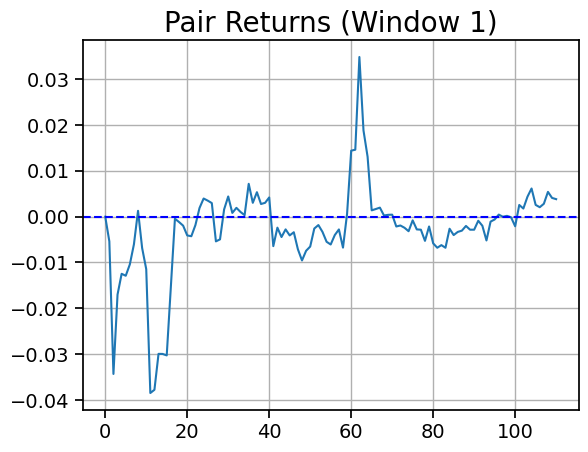

In [228]:
plt.plot(pair_port)
plt.title(f'Pair Returns (Window {rolling_num})')
plt.axhline(y=0, color='blue', linestyle='--')
plt.grid(True)

In [222]:
(-1/out_X[15]) * (out_X[15])


-1.0